In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy import signal
import time
import datetime
import serial
from scipy.fftpack import fft,ifft
from matplotlib.pylab import mpl
import struct
import os
import serial
from pathlib import Path

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
!python.exe -m PyQt5.uic.pyuic Automated_testingV1.6.ui -o Automated_testingV16.py

In [1]:
!python.exe -m PyQt5.uic.pyuic Automated_testingV1.7.ui -o Automated_testingV17.py

In [58]:
!python.exe -m PyQt5.uic.pyuic Automated_testing.ui -o Automated_testing.py

In [185]:
import serial
import time

class turnTable3x:
    def __init__(self):
        self.list_debugMsg = []
        self.list_showMsg = []
        self.list_mode = [0, 0, 0]  # 运行模式
        self.list_commandLocation = [0, 0, 0]
        self.list_commandSpeed = [0, 0, 0]
        self.list_commandAcceleration = [10, 10, 10]
        self.flag_theading = False
        self.serial = None
        self.serial_com = 'COM1'
        self.serial_check = False

    def append_debugMsg(self, msg):
        if isinstance(msg, list):
            msg = ', '.join([str(i) for i in msg])
        self.list_debugMsg.append(str(msg))
        while len(self.list_debugMsg) > 10:
            self.list_debugMsg.pop(0)

    def append_showMsg(self, msg):
        if isinstance(msg, list):
            msg = ', '.join([str(i) for i in msg])
        self.list_showMsg.append(str(msg))
        while len(self.list_showMsg) > 100:
            self.list_showMsg.pop(0)
    # 调试信息清除
    def append_msgClear(self):
        self.list_showMsg.clear()
        self.list_debugMsg.clear()
    def serial_open(self):
        if self.serial is None:
            try:
                self.serial = serial.Serial(self.serial_com, 115200)
            except Exception as e:
                self.append_debugMsg('开启串口异常: {}'.format(e))
                self.serial = None
        else:
            try:
                self.serial.close()
                self.serial = None
                self.serial = serial.Serial(self.serial_com, 115200)
            except Exception as e:
                self.append_debugMsg('重启串口异常: {}'.format(e))
                self.serial = None

    def serial_close(self):
        if self.serial is None:
            return True
        else:
            try:
                self.serial.close()
                self.serial = None
            except Exception as e:
                self.append_debugMsg('重启串口异常: {}'.format(e))
    # 尝试读取串口数据
    def serial_tryRec(self, tryCount=20, waitTime=0.01):
        print('tryCount:{},waitTime{}'.format(tryCount, waitTime))
        count = 0
        while count < tryCount:
            count += 1
            try:
                wait = self.serial.in_waiting
                if wait > 0:
                    recdata = self.serial.read(wait)
                    return recdata
            except Exception as e:
                self.append_debugMsg('获取数据错误: {}'.format(e))
            time.sleep(waitTime)
        print('串口未收到内容:{}'.format(count))
        return False
    def serial_try_clear(self):
        try:
            wait = self.serial.in_waiting
            if wait > 0:
                rec_data = self.serial.read(wait)
                return rec_data
            else:
                return False
        except Exception as e :
            return False
                
    # 尝试发送和读取校验
    def sendAndRec(self, sendMsg='', recMsg=''):
        clear_result = self.serial_try_clear()
        if clear_result:
            print('清理转台控制缓存区:{}'.format(clear_result))
        if len(sendMsg) > 0:
            # print('sendMsg: {}'.format(sendMsg))
            try:
                self.serial.write(sendMsg.encode())
            except Exception as e:
                self.append_debugMsg('tt_chk send error: {}'.format(e))
                return False
        try:
            rec = self.serial_tryRec()
            if not rec:
                self.append_debugMsg('未接收到转台指令')
                return False
            if len(recMsg) > 0:
                if isinstance(recMsg, list):
                    if all(item in rec.decode() for item in recMsg):
                        return True
                elif isinstance(recMsg, str):
                    if recMsg in rec.decode():
                        return True
                else:
                    self.append_showMsg('回读校验失败: {}'.format(recMsg))
                    self.append_debugMsg(
                        '回读校验失败: send:<{}> check:<{}> rec:<{}>'.format(sendMsg, recMsg, rec.decode())
                    )
                    return False
            else:
                return rec.decode()
        except Exception as e:
            self.append_debugMsg('tt_chk rec error: {}'.format(e))
            return False
        return False

    # 通讯校验和
    def sumCheckAscii(self, string):
        return sum(ord(c) for c in string) & 0xFF

    # 通讯检查
    def sendMsg_chk(self):
        return self.sendAndRec('$MNCHK,1*CE\r\n', '$ASCHK,OK*30')
    # 进入远控
    def sendMsg_rem(self):
        return self.sendAndRec('$MNREM,1*DC\r\n', '$ASREM,OK*3E')
    # 返回本控
    def sendMsg_loc(self):
        return self.sendAndRec('$MNLOC,1*D6\r\n', '$ASLOC,OK*38')
    # 使能
    def sendMsg_enb(self):
        return self.sendAndRec('$MNENB,1*CD\r\n', '$ASENB,OK*2F')
    # 断开使能
    def sendMsg_dis(self):
        return self.sendAndRec('$MNDIS,1*D8\r\n', '$ASDIS,OK*3A')
    # 转台寻零
    def sendMsg_hmz(self):
        return self.sendAndRec('$MNHMZ,1*E7\r\n', '$ASHMZ,OK*49')
    # 运行模式
    def sendMsg_mod(self, a, b, c):
        msg_list = [a, b, c]
        for i in msg_list:
            if str(i) not in ['0', '1', '2']:
                self.append_showMsg('转台运行模式设置错误: {}'.format([a, b, c]))
                return False
        sendMsg = 'MNMOD,{},{},{}'.format(a, b, c)
        # recMsg = 'ASMOD,{},{},{},OK'.format(a, b, c)
        recMsg = ['ASMOD','OK']
        return self.sendAndRec(
            '${}*{:02X}\r\n'.format(sendMsg, self.sumCheckAscii(sendMsg)),
            recMsg
            )
    # 位置设置
    def sendMsg_pos(self, a, b, c):
        msg_list = [a, b, c]
        for i in msg_list:
            try:float(i)
            except:
                self.append_showMsg('转台位置设置错误: {}'.format([a, b, c]))
                return False
        sendMsg = 'MNPOS,{},{},{}'.format(a, b, c)
        # recMsg = 'ASPOS,{},{},{},OK'.format(a, b, c)
        recMsg = ['ASPOS','OK']
        return self.sendAndRec(
            '${}*{:02X}\r\n'.format(sendMsg, self.sumCheckAscii(sendMsg)),
            recMsg
            )
    # 速度设置
    def sendMsg_vel(self, a, b, c):
        msg_list = [a, b, c]
        send_list = []
        for i in msg_list:
            try:send_list.append(float(i))
            except:
                self.append_showMsg('转台速度设置错误: {}'.format([a, b, c]))
                return False
        sendMsg = 'MNVEL,{},{},{}'.format(a, b, c)
        # recMsg = 'ASVEL,{},{},{},OK'.format(a, b, c)
        recMsg = ['ASVEL','OK']
        return self.sendAndRec(
            '${}*{:02X}\r\n'.format(sendMsg, self.sumCheckAscii(sendMsg)),
            recMsg
            )
    # 加速度设置
    def sendMsg_acc(self, a, b, c):
        msg_list = [a, b, c]
        for i in msg_list:
            try:float(i)
            except:
                self.append_showMsg('转台加速度设置错误: {}'.format([a, b, c]))
                return False
        sendMsg = 'MNACC,{},{},{}'.format(a, b, c)
        # recMsg = 'ASACC,{},{},{},OK'.format(a, b, c)
        recMsg = ['ASACC','OK']
        return self.sendAndRec(
            '${}*{:02X}\r\n'.format(sendMsg, self.sumCheckAscii(sendMsg)),
            recMsg
            )
    # 运行
    def sendMsg_run(self):
        return self.sendAndRec('$MNRUN,1*ED\r\n', '$ASRUN,OK*4F')
    # 停止
    def sendMsg_stp(self):
        return self.sendAndRec('$MNSTP,1*EF\r\n', '$ASSTP,OK*51')
    # 状态查询
    def sendMsg_sts(self):
        return self.sendAndRec('$MNSTS,1*F2\r\n', '')

In [186]:
test.serial_close()

In [187]:
test = turnTable3x()
test.serial_com = 'COM58'
test.serial_open()

In [189]:
print(test.sendMsg_pos(10,10,10))
print(test.sendMsg_vel(0.5,0.5,0.5))

print(test.list_showMsg)
print(test.list_debugMsg)

tryCount:20,waitTime0.01
True
tryCount:20,waitTime0.01
True
[]
[]


In [196]:
# print(test.sendMsg_run())
# print(test.sendMsg_stp())
print(test.sendMsg_sts())
print(test.list_showMsg)
print(test.list_debugMsg)
test.append_msgClear()

tryCount:20,waitTime0.01
$ASSTS,6.5856,0.500, 31D,6.5861,0.500, 31D,6.5803,0.500,  1D,OK*A6

[]
[]


转动中  31D 31D 1D
已停止  30D 30D D   

In [29]:
print(test.sendMsg_stp())
print(test.list_showMsg)
print(test.list_debugMsg)
test.append_msgClear()

True
[]
[]


In [66]:
test = serial.Serial('com58','115200')
begin_time = time.time()
test.write('$MNSTS,1*F2\r\n'.encode())
while True:
    wait = test.in_waiting
    if wait>0:
        print(test.read(wait).decode())
        break
print('耗时:{:.4f}s'.format(time.time()-begin_time))
test.close()

$ASSTS,359.9999,0.000, 30D,0.0000,0.000, 30D,359.9999,0.000,   D,OK*60

耗时:0.1909s


In [41]:
test.close()

In [27]:
test.sendMsg_vel(12.3456,-123.4567,'10.0000')

sendMsg: $MNVEL,12.3456,-123.4567,10.0000*7F



False

In [36]:
test.sendMsg_acc('10.0000','20.0000','30.0000')

sendMsg: $MNACC,10.0000,20.0000,30.0000*D6



False

In [14]:
a = [1,2,2]
a.clear()
a

[]

In [34]:
hex(test.sumCheckAscii('ASVEL,12.3456,-123.4567,10.0000,OK'))

'0x3e'

In [12]:
0x7f-0xd1

False

In [31]:
# ascii码82转字符
chr(82)

'R'

In [197]:
from funs.fun_checks import *


In [ ]:

def calculate_crc16_mcrf4xx(data: bytearray):
    crc = 0xFFFF
    tmp = 0
    for i in range(len(data)):
        tmp = data[i]^(crc&0xFF)
        tmp^=tmp<<4
        tmp&0xffff
        crc = (crc>>8)^(tmp<<8)^(tmp<<3)^(tmp>>4)
    return crc & 0xFFFF

In [ ]:

def calculate_crc16_mcrf4xx(data: bytearray):
    crc = 0xFFFF  # unsigned short 初始值
    for b in data:
        tmp = b ^ (crc & 0xFF)
        tmp &= 0xFFFF  # 保留 16 位
        tmp ^= (tmp << 4) & 0xFFFF
        tmp &= 0xFFFF  # 保留 16 位
        crc = ((crc >> 8) ^ ((tmp << 8) & 0xFFFF) ^ ((tmp << 3) & 0xFFFF) ^ (tmp >> 4))
        crc &= 0xFFFF  # 保留 16 位
    return crc & 0xFFFF
data = 'FE 10 00 00 00 03 40 64 6F 0A'+' 00'*12
data = 'FE 10 00 00 00 03 40 64 6F 0A'+' 00'*12
print('<{}>'.format(data))
print(bytes.fromhex(data).hex())
print('{:04X}'.format(calculate_crc16(bytes.fromhex(data))))
print('{:04X}'.format(calculate_crc32(bytes.fromhex(data))))
print('{:04X}'.format(calculate_crc16_mcrf4xx(bytes.fromhex(data))))

<FE 10 00 00 00 03 40 64 6F 0A 00 00 00 00 00 00 00 00 00 00 00 00>
fe100000000340646f0a000000000000000000000000
B62F
712D04E1
5E6B


In [6]:
filename = 'E:/Data/8357/振动/8357_振动_X_协议_20250731143118_hex.hex'
with open(filename, 'rb') as f:
    data = f.read()
test_data = data[39:39+57]

In [26]:
test = '55aaab00000002960003a22935833bff35ba6f6fb71a4626ba0befaf3d47b5703b179708025b025b026f02a1029500000000000000000500010033eb9033c0ff669979eb903318a0000014e907082333bc0273a1f1060728aa000000000000000000660079000f010000190000000e86eb90331802ab0000000000000000c0ffaabb74e8073b1d11001e7b6283d1dc4340c1f20537ed1f5d40db40616cdf2d3b40d540c13c5d1fbc3bf29f843836012ebfa9e708c0ac41d3421400010200c0ff'
test_data = bytes.fromhex(test)
print(hex(sum(test_data[67:126])))
print(hex(test_data[66]))

0xb79
0x79


In [25]:
test = b'\x90\xeb4\x00\xaaU\xaaU\xf4\xff\xd4\x91\xd8R\x9d\xe1@<?\x86%\x00\x00\x00\x00\x00\x00\x00\xb69\xce\xff9\x00%\x01\xe0\xfc-\x01@\r\x00\x01\x01\x01\x00\x00\x00\x00\x00\x00\x0b\x0b\x00\x00\x03'
print(sum(test[2:56])&0xff)
print(hex(sum(test[2:56])))
print(test[56])
print(hex(test[-1]))

35
0xf23
3
0x3


In [31]:
filename ='E:/Data/8357/跑车/8357跑车_通用_20250807171726_hz.txt'
df = pd.read_csv(filename, sep='\t', header=None)
print(len(df))

1102400


In [ ]:
df = df[df[24]<117]
df = df[df[24]>116.47]
df = df[df[25]<40]
df = df[df[25]>39]
print(len(df))

21300


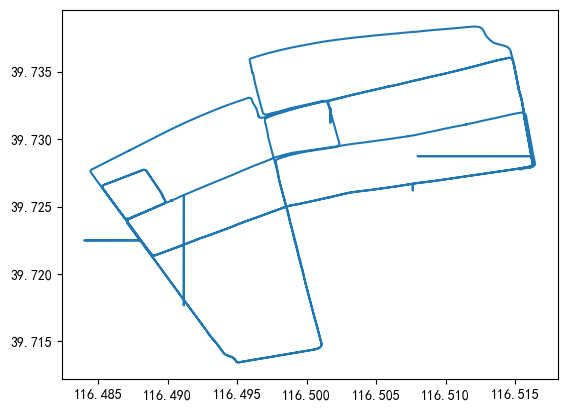

In [38]:
plt.plot(df[24],df[25])

In [47]:
diff_data1 = df[24].diff()
diff_data2 = df[25].diff()
df2 = df
df2 = df2[diff_data1 <0.002]
df2 = df2[diff_data1 >-0.002]
df2 = df2[diff_data2 <0.002]
df2 = df2[diff_data2 >-0.002]

C:\Users\chy\AppData\Local\Temp\ipykernel_6052\3606290349.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[diff_data1 >-0.002]
C:\Users\chy\AppData\Local\Temp\ipykernel_6052\3606290349.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[diff_data2 <0.002]
C:\Users\chy\AppData\Local\Temp\ipykernel_6052\3606290349.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[diff_data2 >-0.002]


In [54]:
for i in range(3):
    df2 = df2[df2[27+i]<100]
    df2 = df2[df2[27+i]>-20]

In [86]:
df2 = df2[df2[14]>0]

In [87]:
df2.to_csv('E:/Work/理工导航/General_autoTest_Host/测试数据/202508/14/8357跑车_基准_20250814023250_s.txt', index=False,sep='\t',header=None)

In [4]:
import re

In [16]:
filename = '129#05_slsBD_BD1#loc[0.0_0.0_0.0_0.0]#20250604112712_hz.png'
list_pathrule_and = [['s','txt'],['png']]
list_pathrule_nor = [['#loc'],['_hz']]
any([all([re.search(r, filename) for r in rule]) for rule in list_pathrule_and])

True

In [12]:
rule =  ['s','png']
any([re.search(r, filename) for r in rule])

True